In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import os
import dill

In [2]:
# Define the selected features for each ticker
selected_features = {
    'BND_enrich.csv': ["3day MA", "Returns", "DGS10", "10day MA", "breakeven_rate", "VIXCLS", "month", "DFII10", "day", "IRLTLT01USM156N", "EMVMACROBUS", "Std_dev", "EMVOVERALLEMV", "CPALTT01USM661S", "PAYEMS", "EMVMACROINTEREST", "RBUSBIS"],
    'GLD_enrich.csv': ["Returns", "3day MA", "day", "Std_dev", "10day MA", "O-C", "month", "Volume", "EMVMACROINTEREST", "WALCL", "FEDFUNDS", "VIXCLS", "DGS3MO", "DGS10", "EMVMACROBUS", "PAYEMS", "CPALTT01USM661S", "EMVOVERALLEMV", "VOL", "year", "H-L", "GDPC1", "DFII10", "IRLTLT01USM156N", "RBUSBIS", "breakeven_rate", "Buy_Sell", "Buy_Sell_on_Open", "Increase_Decrease"],
    'GOVT_enrich.csv': ["3day MA", "DGS10", "breakeven_rate", "DGS2", "Returns", "DFII10", "EMVOVERALLEMV", "IRLTLT01USM156N", "month", "CPALTT01USM661S", "Std_dev", "PAYEMS", "VIXCLS"],
    'IVOO_enrich.csv': ["VIXCLS", "3day MA", "Returns", "month", "10day MA", "O-C", "EMVOVERALLEMV", "VOL", "WALCL", "CPALTT01USM661S", "Std_dev", "EMVMACROINTEREST", "DFII10", "day", "GDPC1", "year", "EMVMACROBUS", "IRLTLT01USM156N", "DGS10", "PAYEMS", "DGS3MO", "breakeven_rate", "Volume", "Buy_Sell_on_Open", "H-L"],
    'JNK_enrich.csv': ["3day MA", "Returns", "VIXCLS", "10day MA", "month", "O-C", "EMVOVERALLEMV", "breakeven_rate", "Std_dev", "VOL", "EMVMACROINTEREST", "GDPC1", "EMVMACROBUS", "IRLTLT01USM156N", "CPALTT01USM661S", "day", "DFII10", "DGS10", "PAYEMS", "DGS3MO", "Volume"],
    'SPY_enrich.csv': ["Returns", "VIXCLS", "month", "O-C", "10day MA", "Volume", "VOL", "CPALTT01USM661S", "day", "EMVOVERALLEMV", "WALCL", "EMVMACROINTEREST", "breakeven_rate", "GDPC1"],
    'VIOO_enrich.csv': ["Returns", "VIXCLS", "3day MA", "O-C", "10day MA", "month", "CPALTT01USM661S", "GDPC1", "DGS3MO", "Std_dev", "DFII10", "day", "IRLTLT01USM156N", "PAYEMS", "EMVOVERALLEMV", "VOL", "year", "H-L", "EMVMACROINTEREST", "EMVMACROBUS", "FEDFUNDS", "WALCL", "Buy_Sell_on_Open", "DGS2", "breakeven_rate"],
    'VOO_enrich.csv': ["3day MA", "VIXCLS", "Returns", "month", "10day MA", "O-C", "VOL", "CPALTT01USM661S", "GDPC1", "DGS3MO", "EMVMACROINTEREST", "day", "DFII10", "IRLTLT01USM156N", "EMVMACROBUS", "H-L", "FEDFUNDS"]
}

# Manually set which ticker to work on
ticker = 'BND_enrich.csv'  # Replace with the desired ticker file name

np.random.seed(2023)
print(f"Processing ticker: {ticker}")

Processing ticker: BND_enrich.csv


In [4]:
tickers = list(selected_features.keys())

for ticker in tickers:
    print(f"Processing ticker: {ticker}")
    
    # Processing steps (unchanged)
    stock_data = pd.read_csv(ticker)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data['VOL'] = (stock_data['High'] - stock_data['Low']) / stock_data['Open'] * 100
    stock_data = stock_data.drop(columns=['Open', 'High', 'Low'])
    stock_data = stock_data.dropna(axis=1)
    
    features = selected_features[ticker]
    newdata = stock_data[['Date'] + features + ['Close']]
    
    split_point = len(stock_data) - 90
    xr_train = newdata.iloc[:split_point, 1:-1]
    xr_test = newdata.iloc[split_point:, 1:-1]
    yr_train = newdata.iloc[:split_point, -1]
    yr_test = newdata.iloc[split_point:, -1]
    
    scaler = StandardScaler()
    xr_train_scaled = pd.DataFrame(scaler.fit_transform(xr_train), columns=xr_train.columns)
    xr_test_scaled = pd.DataFrame(scaler.transform(xr_test), columns=xr_test.columns)
    yr_train_scaled = scaler.fit_transform(yr_train.values.reshape(-1, 1)).flatten()
    yr_test_scaled = scaler.transform(yr_test.values.reshape(-1, 1)).flatten()
    
    scaling_params = {'mean': scaler.mean_, 'scale': scaler.scale_}
    
    # Hyperparameter tuning and training for XGBoost
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0]
    }
    
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=2023)
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(xr_train_scaled, yr_train_scaled)
    final_model = grid_search.best_estimator_
    
    print(f"Best parameters for {ticker}: {grid_search.best_params_}")
    print(f"Best cross-validated score for {ticker}: {-grid_search.best_score_}")
    
    # Train data performance (Unscaled)
    train_preds_scaled = final_model.predict(xr_train_scaled)
    train_preds = train_preds_scaled * scaling_params['scale'][-1] + scaling_params['mean'][-1]
    train_rmse = np.sqrt(mean_squared_error(yr_train, train_preds))
    train_mape = mean_absolute_percentage_error(yr_train, train_preds)
    print(f"Train performance for {ticker} - RMSE: {train_rmse}, MAPE: {train_mape}")
    
    # Test data performance (Unscaled)
    test_preds_scaled = final_model.predict(xr_test_scaled)
    test_preds = test_preds_scaled * scaling_params['scale'][-1] + scaling_params['mean'][-1]
    test_rmse = np.sqrt(mean_squared_error(yr_test, test_preds))
    test_mape = mean_absolute_percentage_error(yr_test, test_preds)
    print(f"Test performance for {ticker} - RMSE: {test_rmse}, MAPE: {test_mape}")
    
    # Plot using unscaled values
    plt.figure(figsize=(6, 6))
    plt.plot(newdata['Date'].iloc[split_point:], yr_test, color='black', lw=2, label='Actual')
    plt.plot(newdata['Date'].iloc[split_point:], test_preds, color='red', lw=2, label='Predicted')
    plt.scatter(newdata['Date'].iloc[split_point:], yr_test, color='black', s=10)
    plt.scatter(newdata['Date'].iloc[split_point:], test_preds, color='red', s=10)
    plt.xticks(rotation=45)
    plt.title(f'Test Performance for {ticker}')
    plt.xlabel('')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f'{os.path.splitext(ticker)[0]}_xgboost_performance_plot.png'
    plt.savefig(plot_filename)
    plt.close()
    
    # Save the entire environment for this ticker
    environment_filename = f"environment_{os.path.splitext(ticker)[0]}_xgboost.pkl"
    with open(environment_filename, 'wb') as file:
        dill.dump_session(file)
    
    print(f"Saved environment for {ticker} as {environment_filename}")


Processing ticker: BND_enrich.csv
Best parameters for BND_enrich.csv: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}
Best cross-validated score for BND_enrich.csv: 0.2372627121919347
Train performance for BND_enrich.csv - RMSE: 0.042334381242189, MAPE: 0.0004051664602065994
Test performance for BND_enrich.csv - RMSE: 0.4542562544398126, MAPE: 0.0054528553503181134
Saved environment for BND_enrich.csv as environment_BND_enrich_xgboost.pkl
Processing ticker: GLD_enrich.csv
Best parameters for GLD_enrich.csv: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validated score for GLD_enrich.csv: 0.009222571426571248
Train performance for GLD_enrich.csv - RMSE: 0.8646555801588544, MAPE: 0.004560253628359434
Test performance for GLD_enrich.csv - RMSE: 14.909388687898803, MAPE: 0.04774000261187437
Saved environment for GLD_enrich.csv as environment_GLD_enrich_xgboost.pkl
Processing ticker: GOVT_enrich.csv
Best parameters for

In [3]:
tickers = list(selected_features.keys())

for ticker in tickers:
    print(f"Processing ticker: {ticker}")
    
    # Processing steps (unchanged)
    stock_data = pd.read_csv(ticker)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data['VOL'] = (stock_data['High'] - stock_data['Low']) / stock_data['Open'] * 100
    stock_data = stock_data.drop(columns=['Open', 'High', 'Low'])
    stock_data = stock_data.dropna(axis=1)
    
    features = selected_features[ticker]
    newdata = stock_data[['Date'] + features + ['Close']]
    
    split_point = len(stock_data) - 90
    xr_train = newdata.iloc[:split_point, 1:-1]
    xr_test = newdata.iloc[split_point:, 1:-1]
    yr_train = newdata.iloc[:split_point, -1]
    yr_test = newdata.iloc[split_point:, -1]
    
    scaler = StandardScaler()
    xr_train_scaled = pd.DataFrame(scaler.fit_transform(xr_train), columns=xr_train.columns)
    xr_test_scaled = pd.DataFrame(scaler.transform(xr_test), columns=xr_test.columns)
    yr_train_scaled = scaler.fit_transform(yr_train.values.reshape(-1, 1)).flatten()
    yr_test_scaled = scaler.transform(yr_test.values.reshape(-1, 1)).flatten()
    
    scaling_params = {'mean': scaler.mean_, 'scale': scaler.scale_}
    
    # Hyperparameter tuning and training for XGBoost
    xgb_model = XGBRegressor(objective='reg:squarederror', booster='gblinear', random_state=2023)

    param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],  # Smaller steps and a larger range
    'lambda': [0.01, 0.1, 1, 10, 100],               # More regularization options
    'alpha': [0.01, 0.1, 1, 10, 100],                # More options for sparsity control
    'n_estimators': [50, 100, 200],                  # Number of boosting rounds
    'updater': ['shotgun', 'coord_descent']          # Different methods for optimization
    }


    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(xr_train_scaled, yr_train_scaled)
    final_model = grid_search.best_estimator_

    
    print(f"Best parameters for {ticker}: {grid_search.best_params_}")
    print(f"Best cross-validated score for {tick_er}: {-grid_search.best_score_}")
    
    # Train data performance (Unscaled)
    train_preds_scaled = final_model.predict(xr_train_scaled)
    train_preds = train_preds_scaled * scaling_params['scale'][-1] + scaling_params['mean'][-1]
    train_rmse = np.sqrt(mean_squared_error(yr_train, train_preds))
    train_mape = mean_absolute_percentage_error(yr_train, train_preds)
    print(f"Train performance for {ticker} - RMSE: {train_rmse}, MAPE: {train_mape}")
    
    # Test data performance (Unscaled)
    test_preds_scaled = final_model.predict(xr_test_scaled)
    test_preds = test_preds_scaled * scaling_params['scale'][-1] + scaling_params['mean'][-1]
    test_rmse = np.sqrt(mean_squared_error(yr_test, test_preds))
    test_mape = mean_absolute_percentage_error(yr_test, test_preds)
    print(f"Test performance for {ticker} - RMSE: {test_rmse}, MAPE: {test_mape}")
    
    # Plot using unscaled values
    plt.figure(figsize=(6, 6))
    plt.plot(newdata['Date'].iloc[split_point:], yr_test, color='black', lw=2, label='Actual')
    plt.plot(newdata['Date'].iloc[split_point:], test_preds, color='red', lw=2, label='Predicted')
    plt.scatter(newdata['Date'].iloc[split_point:], yr_test, color='black', s=10)
    plt.scatter(newdata['Date'].iloc[split_point:], test_preds, color='red', s=10)
    plt.xticks(rotation=45)
    plt.title(f'Test Performance for {ticker}')
    plt.xlabel('')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f'{os.path.splitext(ticker)[0]}_xgboostLinear_performance_plot.png'
    plt.savefig(plot_filename)
    plt.close()
    
    # Save the entire environment for this ticker
    environment_filename = f"environment_{os.path.splitext(ticker)[0]}_xgboostLinear.pkl"
    with open(environment_filename, 'wb') as file:
        dill.dump_session(file)
    
    print(f"Saved environment for {ticker} as {environment_filename}")


Processing ticker: BND_enrich.csv
Best parameters for BND_enrich.csv: {'alpha': 0.01, 'lambda': 0.01, 'learning_rate': 0.2, 'n_estimators': 200, 'updater': 'coord_descent'}
Best cross-validated score for BND_enrich.csv: 0.019531635213428277
Train performance for BND_enrich.csv - RMSE: 0.26940574837451786, MAPE: 0.002427064020383529
Test performance for BND_enrich.csv - RMSE: 0.20503847434899616, MAPE: 0.00221421782651996
Saved environment for BND_enrich.csv as environment_BND_enrich_xgboostLinear.pkl
Processing ticker: GLD_enrich.csv
Best parameters for GLD_enrich.csv: {'alpha': 0.01, 'lambda': 0.01, 'learning_rate': 0.2, 'n_estimators': 200, 'updater': 'coord_descent'}
Best cross-validated score for GLD_enrich.csv: 0.00555049380261762
Train performance for GLD_enrich.csv - RMSE: 1.7033951557693312, MAPE: 0.008690811128333777
Test performance for GLD_enrich.csv - RMSE: 3.119028858152302, MAPE: 0.010712218098588114
Saved environment for GLD_enrich.csv as environment_GLD_enrich_xgboostLi

Processing ticker: GLD_enrich.csv
Test performance for GLD_enrich.csv - RMSE: 15.661581062346425, MAPE: 0.05155920578019026


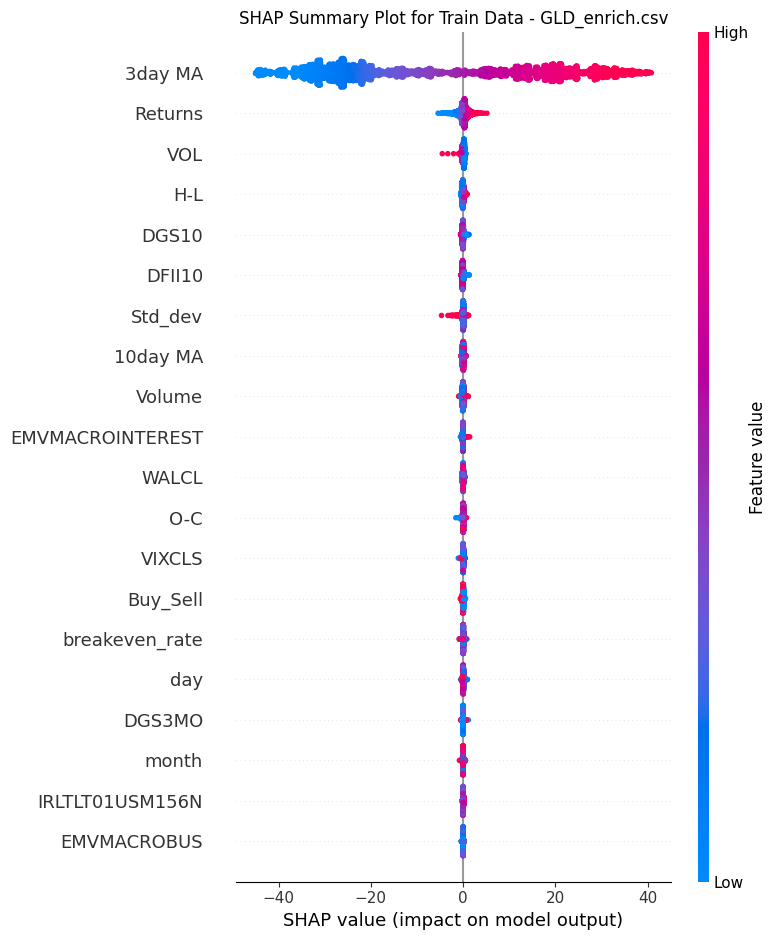

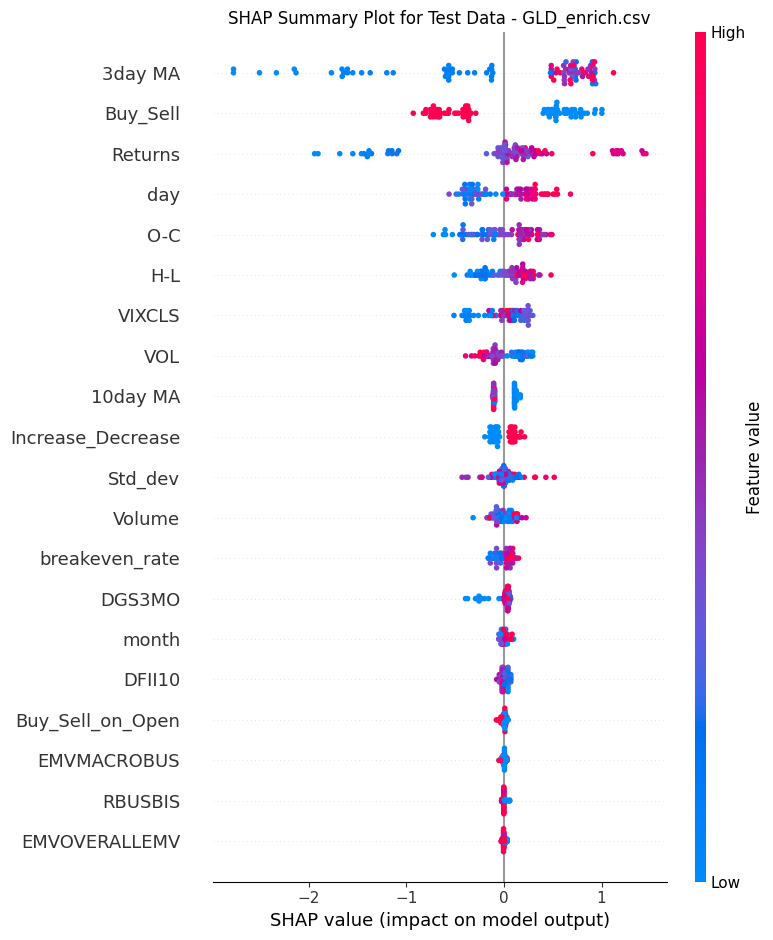

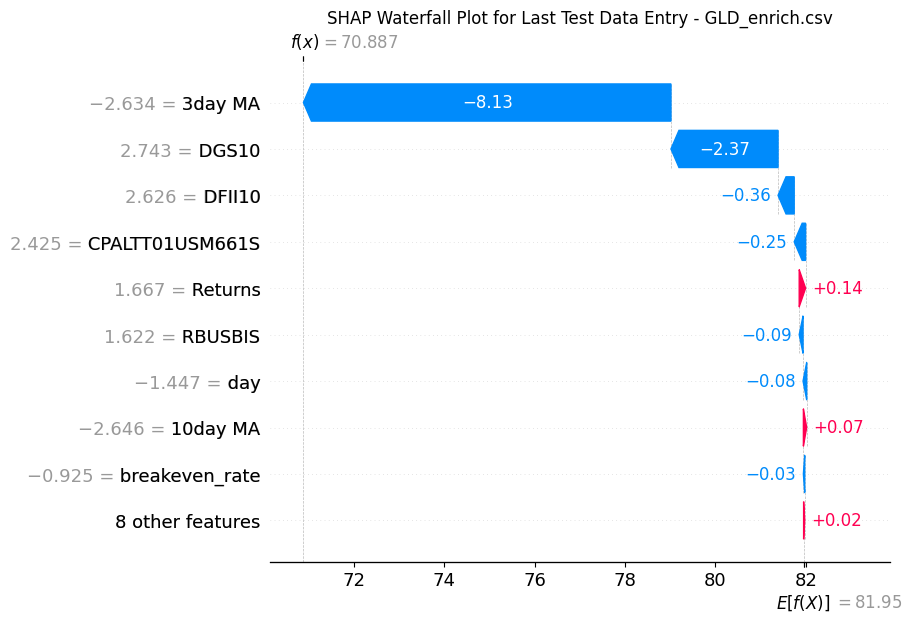

<Figure size 1000x800 with 0 Axes>

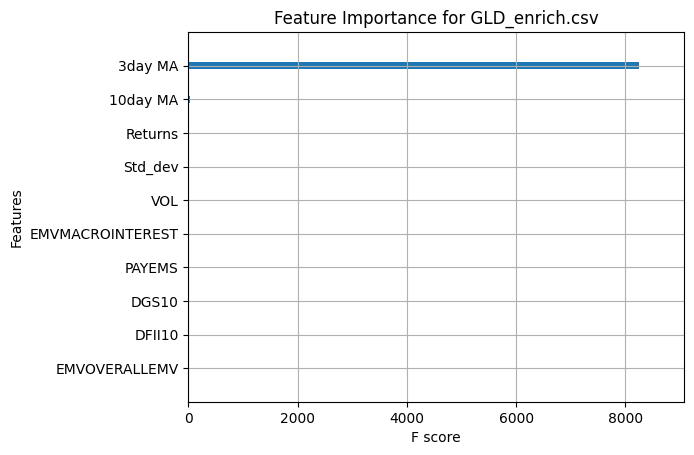

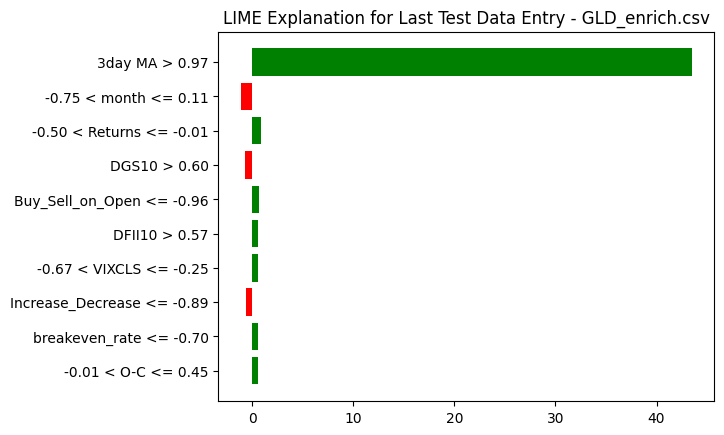

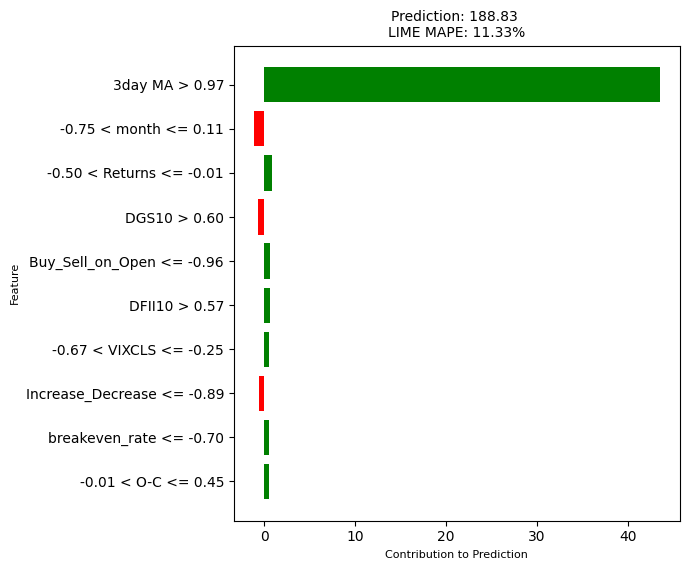

Processing ticker: GOVT_enrich.csv
Test performance for GOVT_enrich.csv - RMSE: 0.1479633365414149, MAPE: 0.005930734246637591


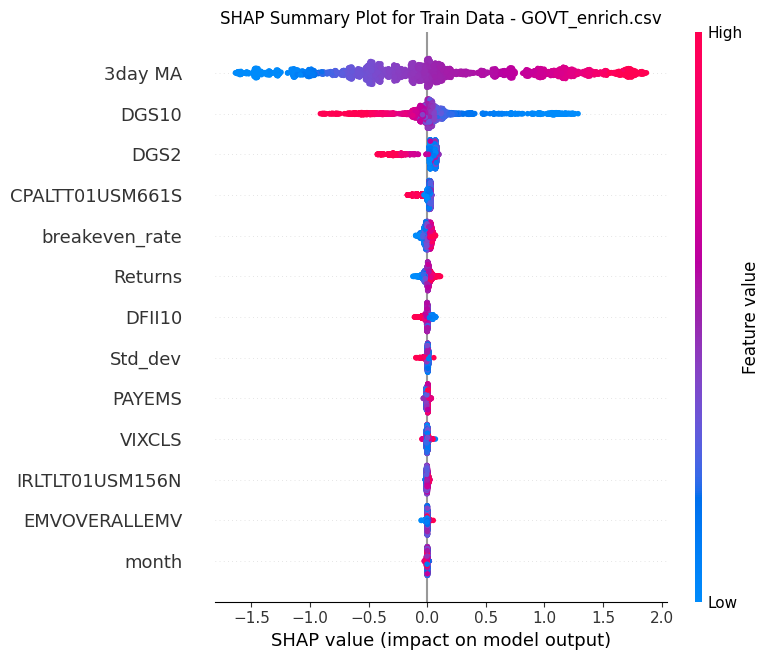

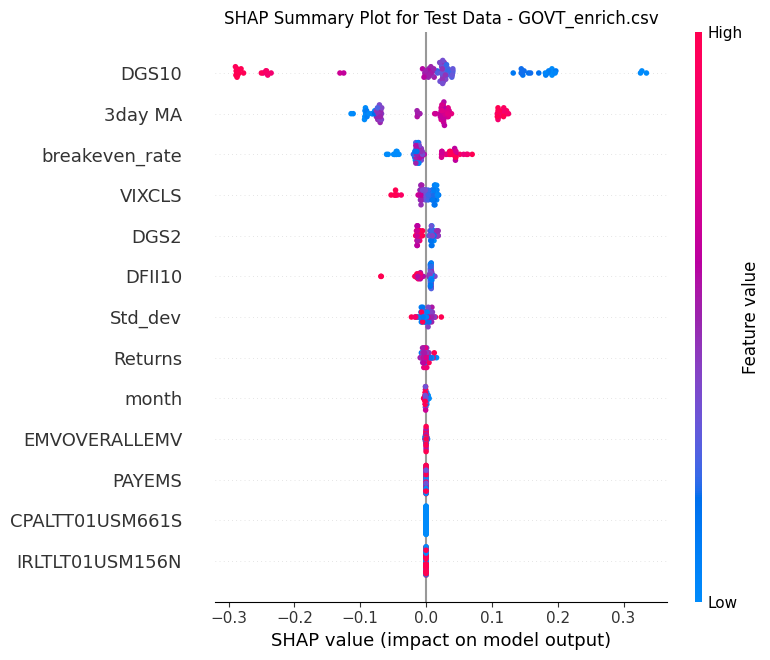

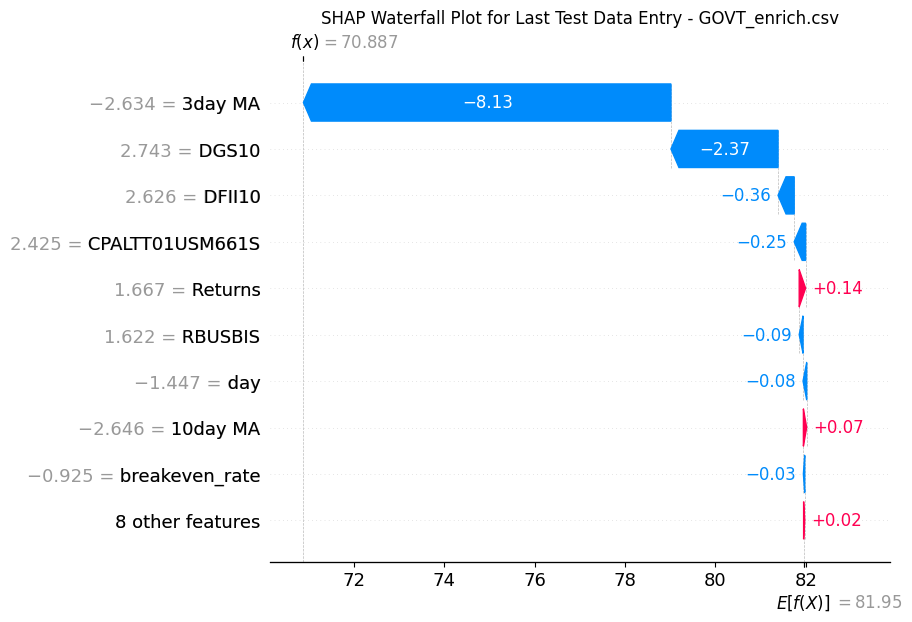

<Figure size 1000x800 with 0 Axes>

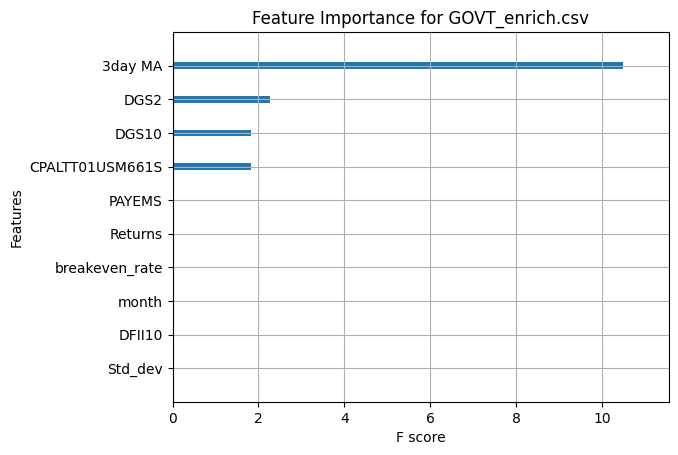

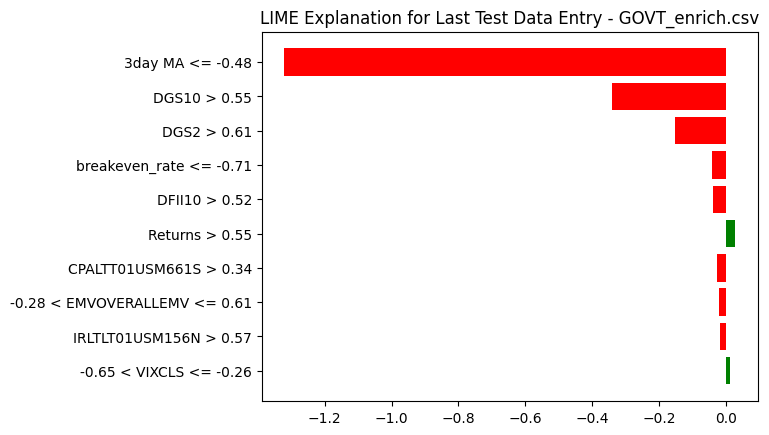

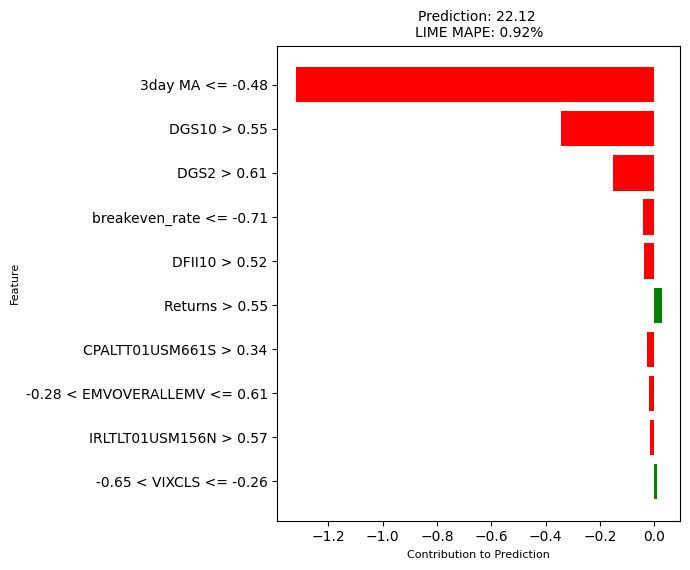

Processing ticker: IVOO_enrich.csv
Test performance for IVOO_enrich.csv - RMSE: 4.484553765993824, MAPE: 0.03695837862147223


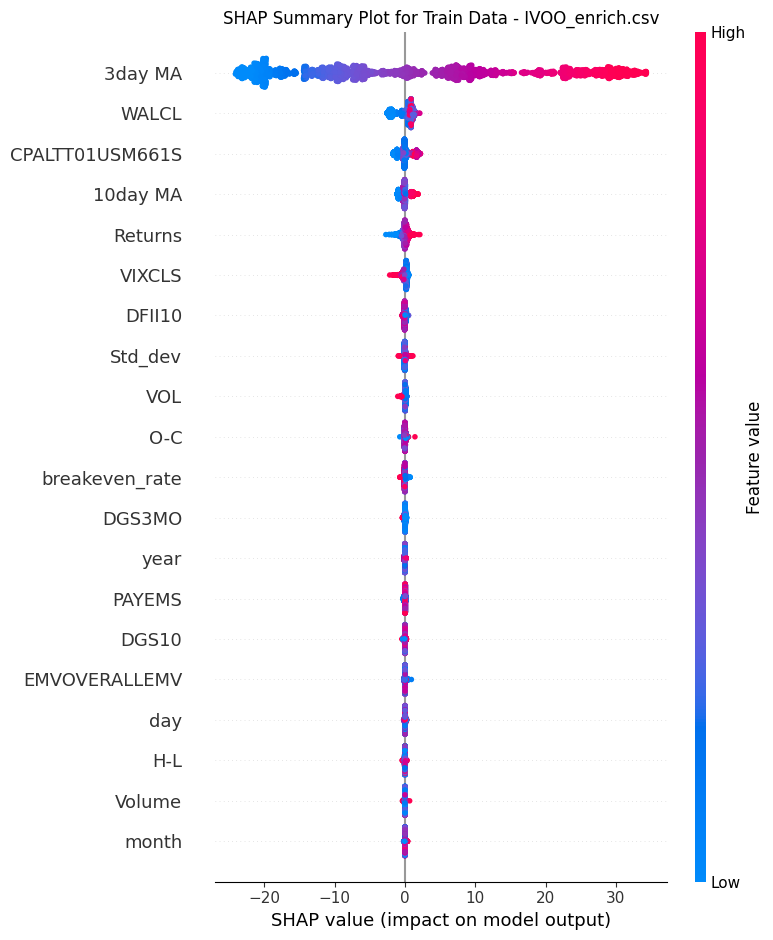

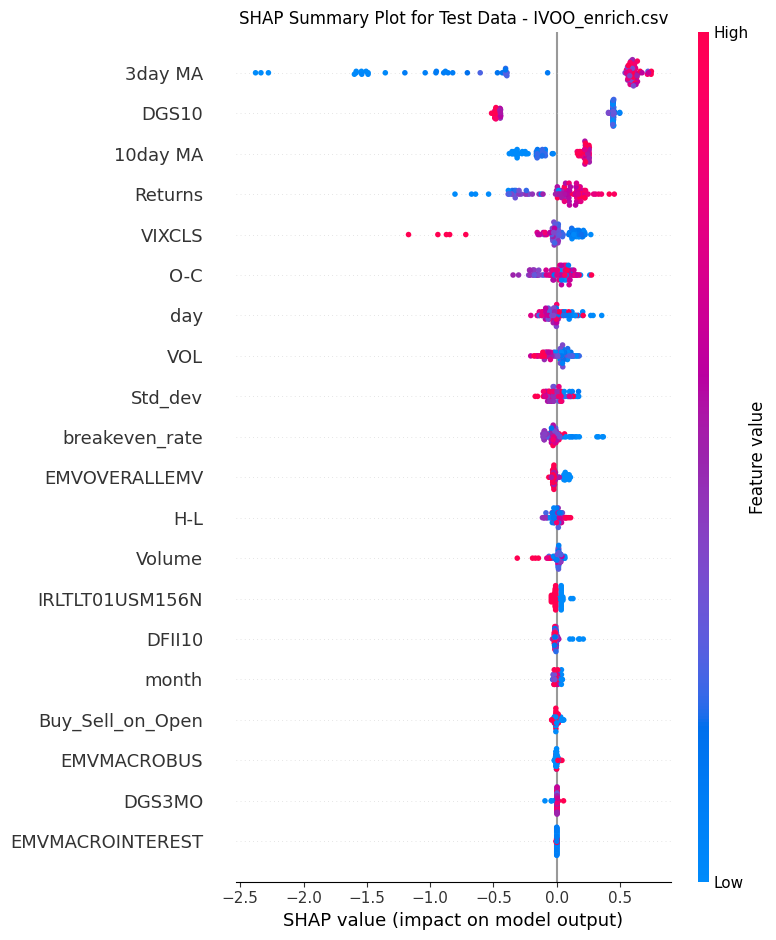

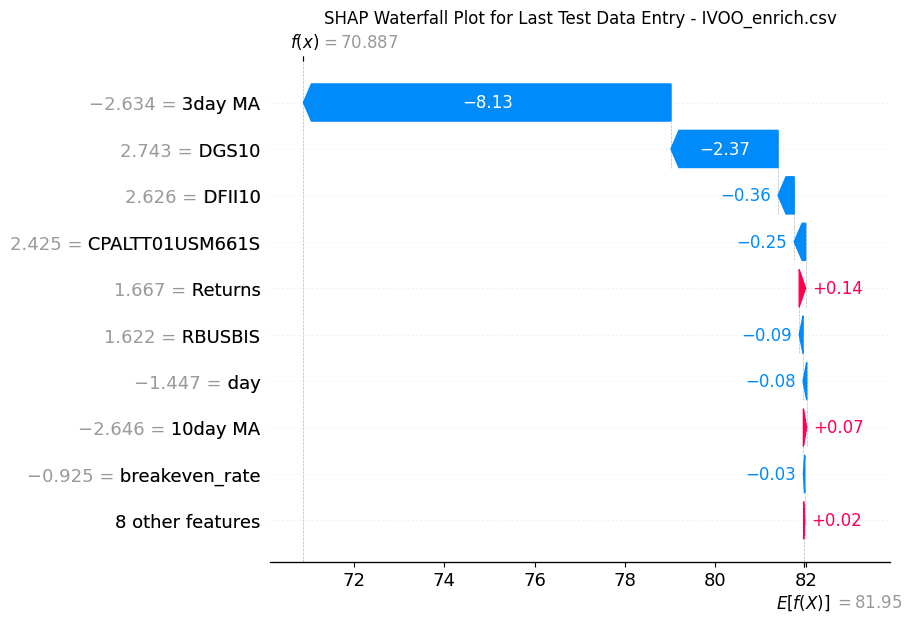

<Figure size 1000x800 with 0 Axes>

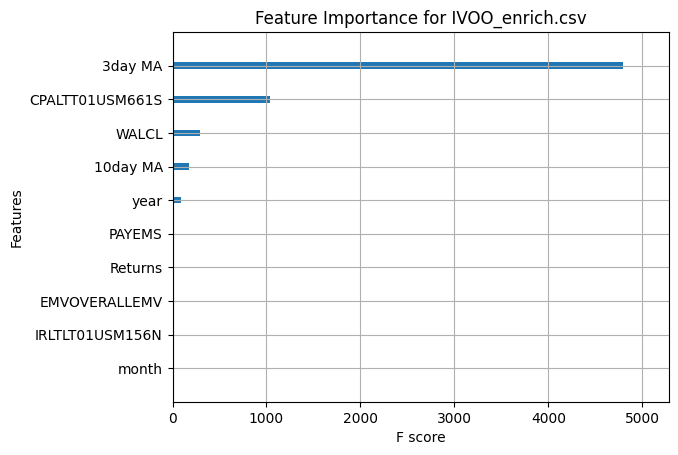

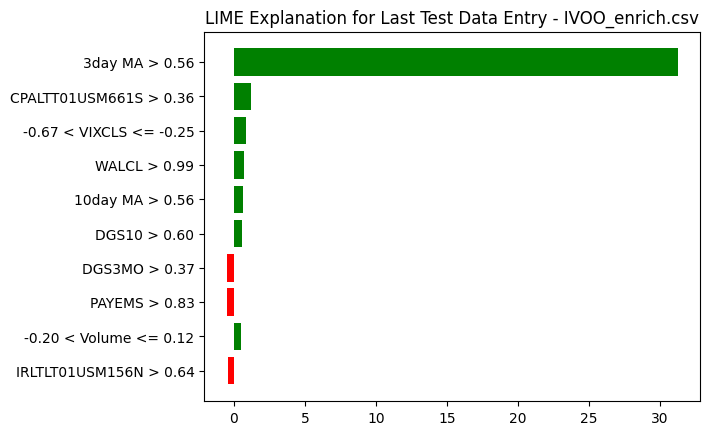

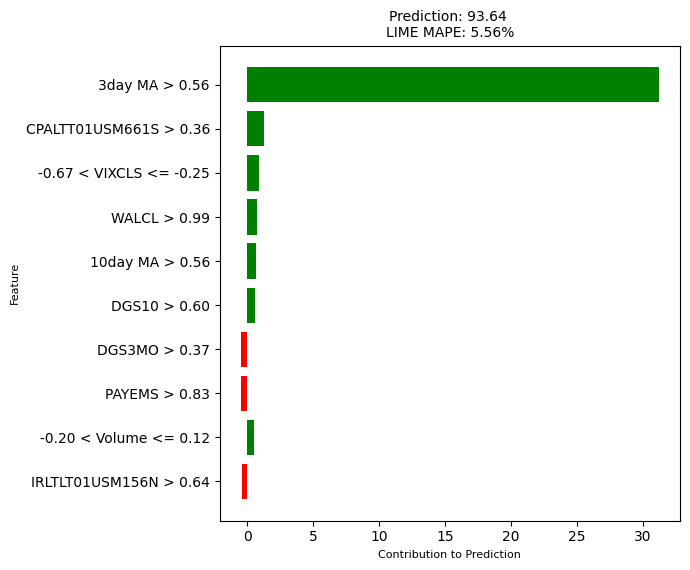

Processing ticker: JNK_enrich.csv
Test performance for JNK_enrich.csv - RMSE: 0.4631033546729629, MAPE: 0.004183058408050021


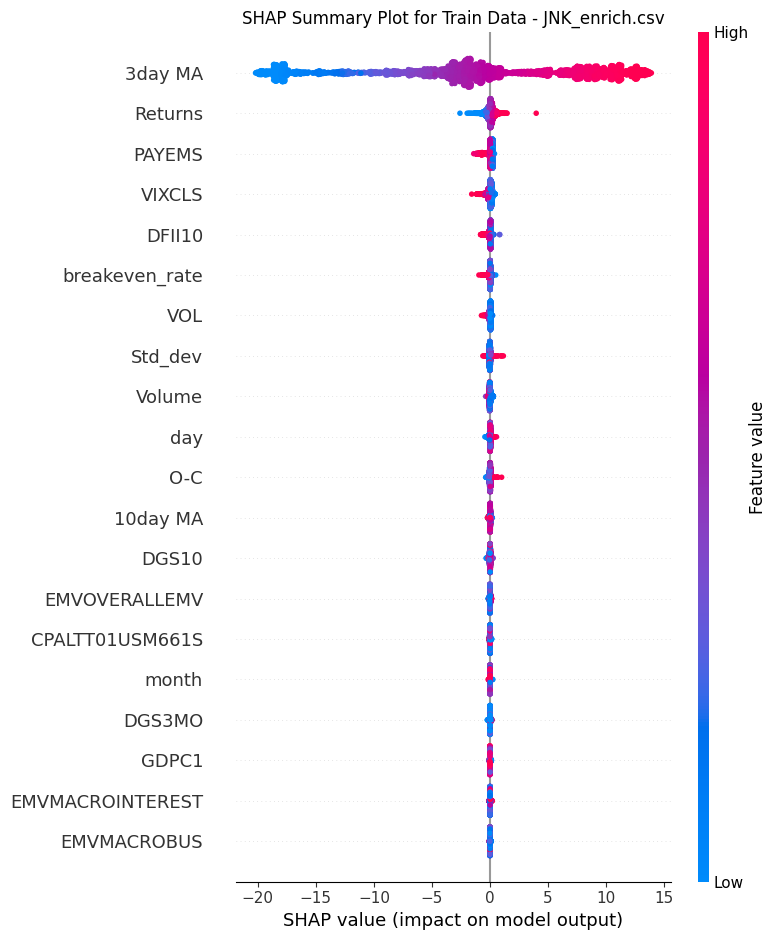

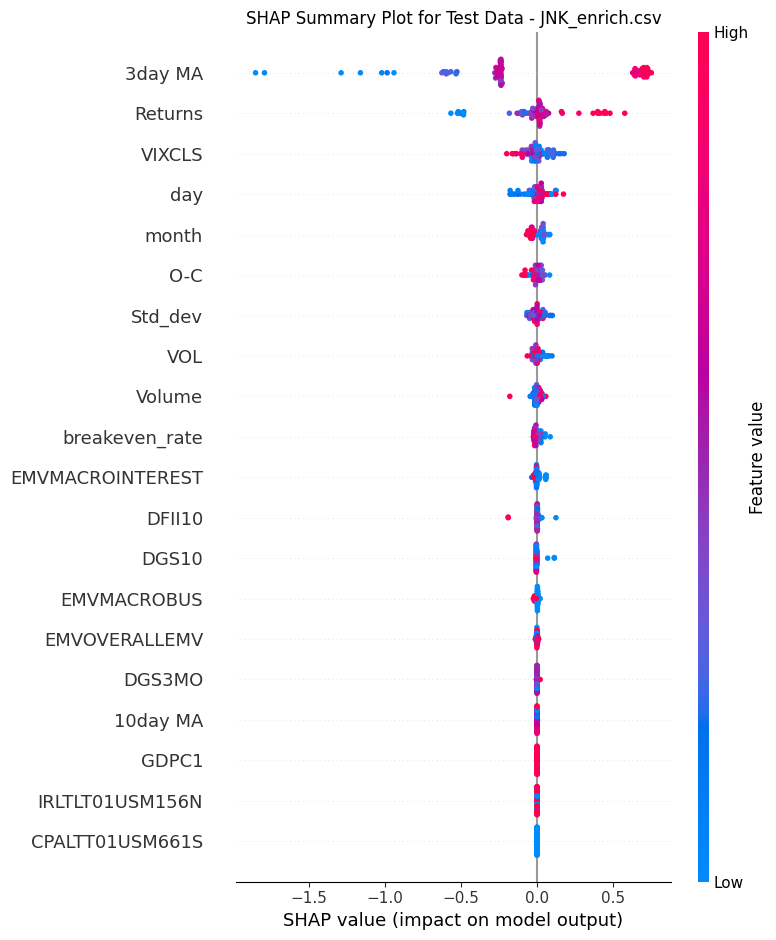

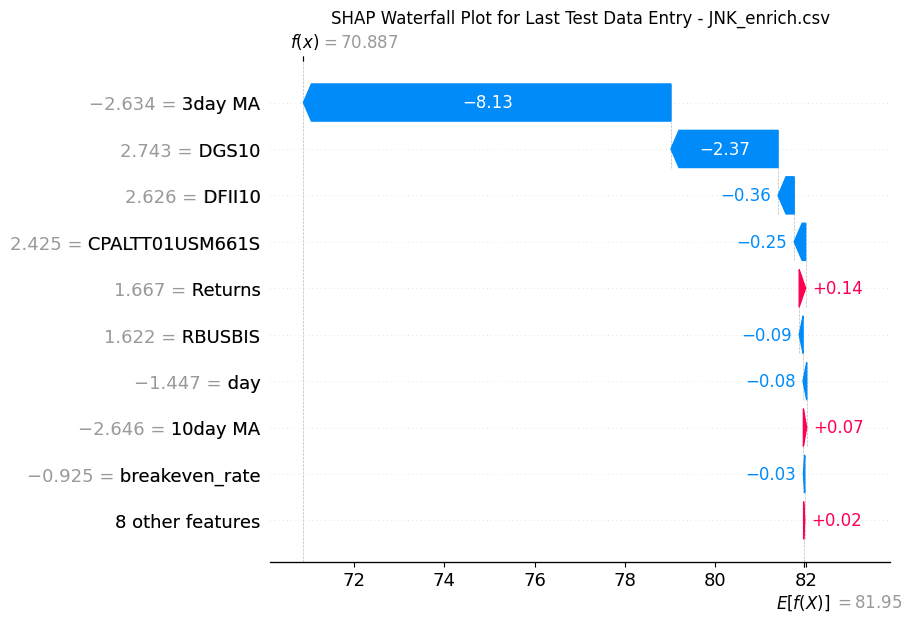

<Figure size 1000x800 with 0 Axes>

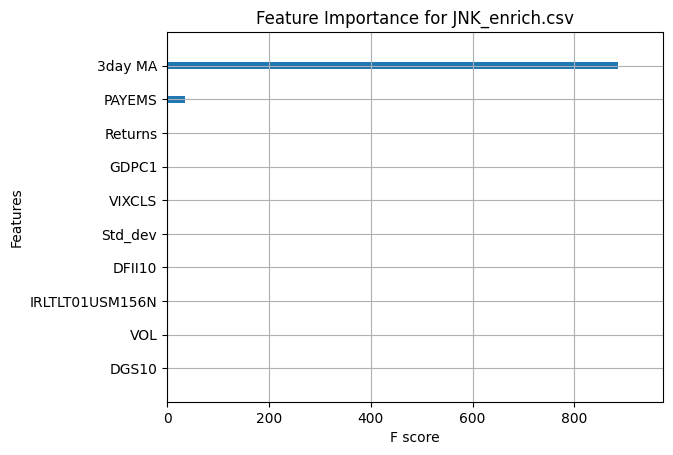

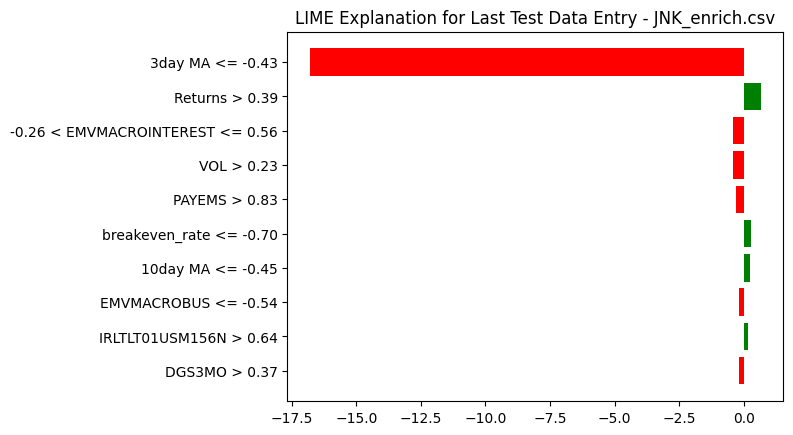

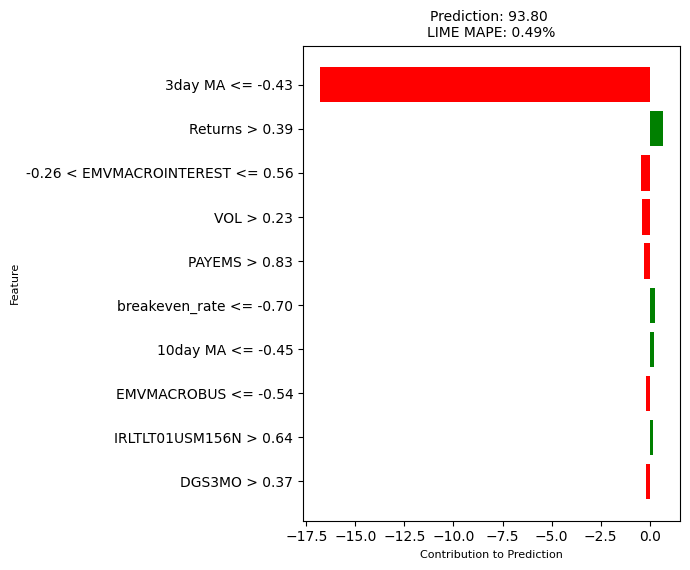

Processing ticker: SPY_enrich.csv
Test performance for SPY_enrich.csv - RMSE: 39.85133962217485, MAPE: 0.0712590386949944


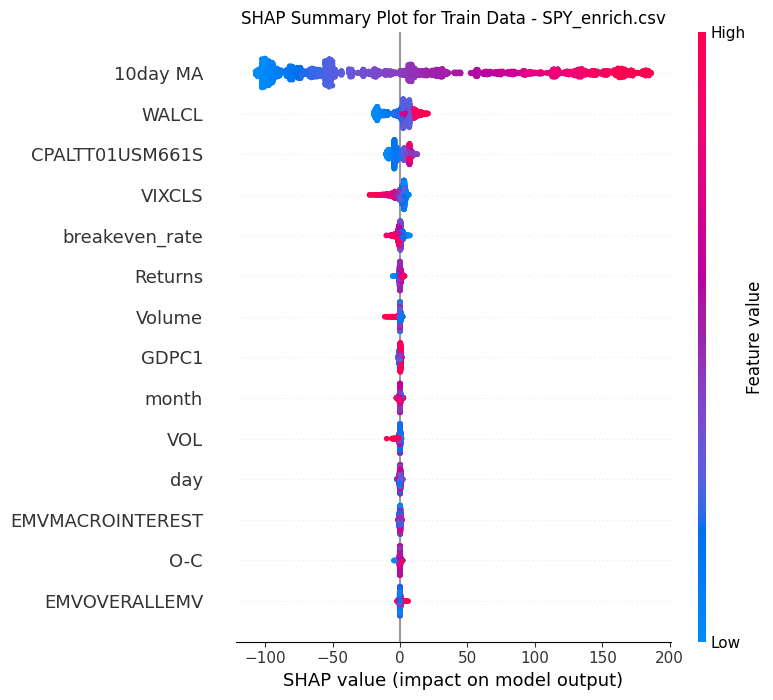

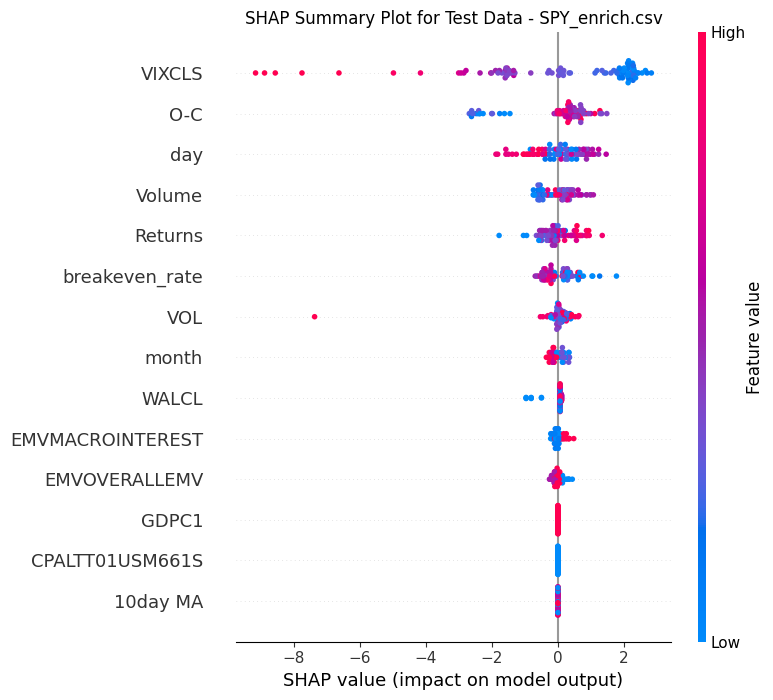

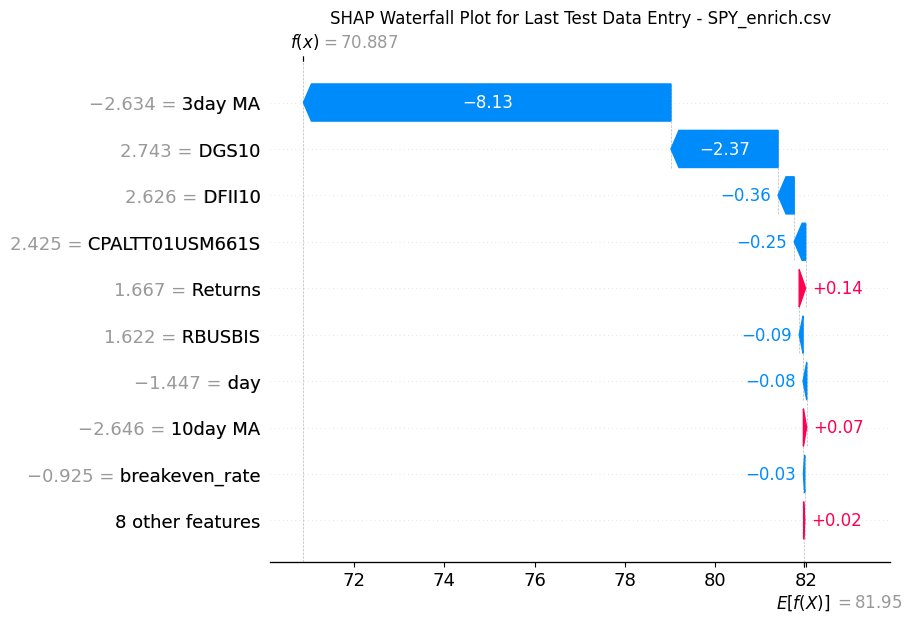

<Figure size 1000x800 with 0 Axes>

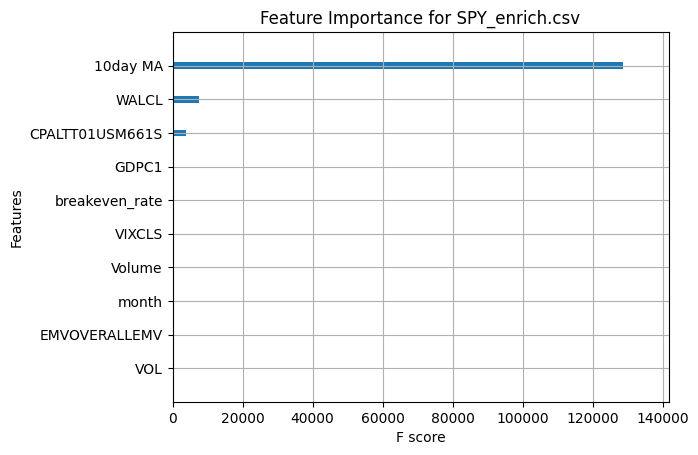

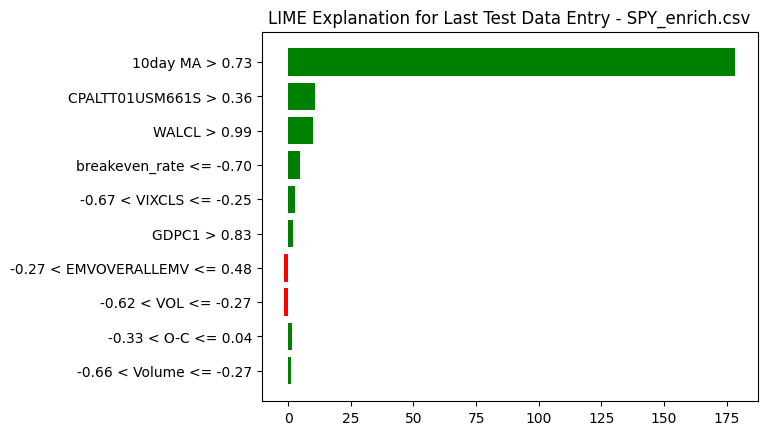

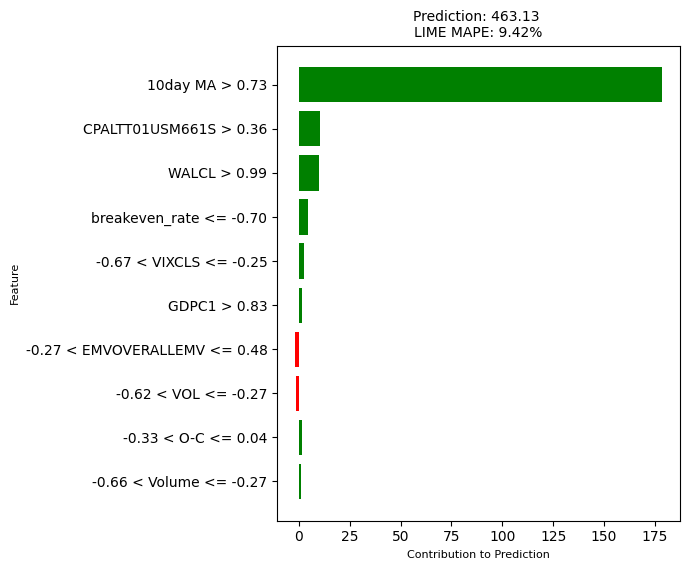

Processing ticker: VIOO_enrich.csv
Test performance for VIOO_enrich.csv - RMSE: 1.353880932996964, MAPE: 0.010895754128212472


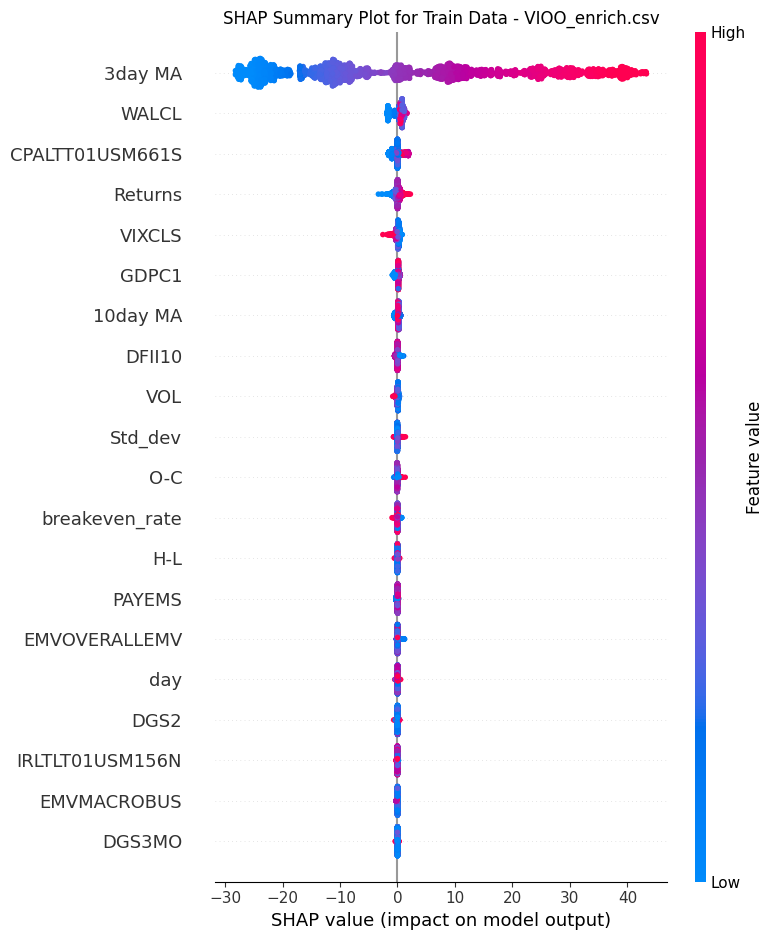

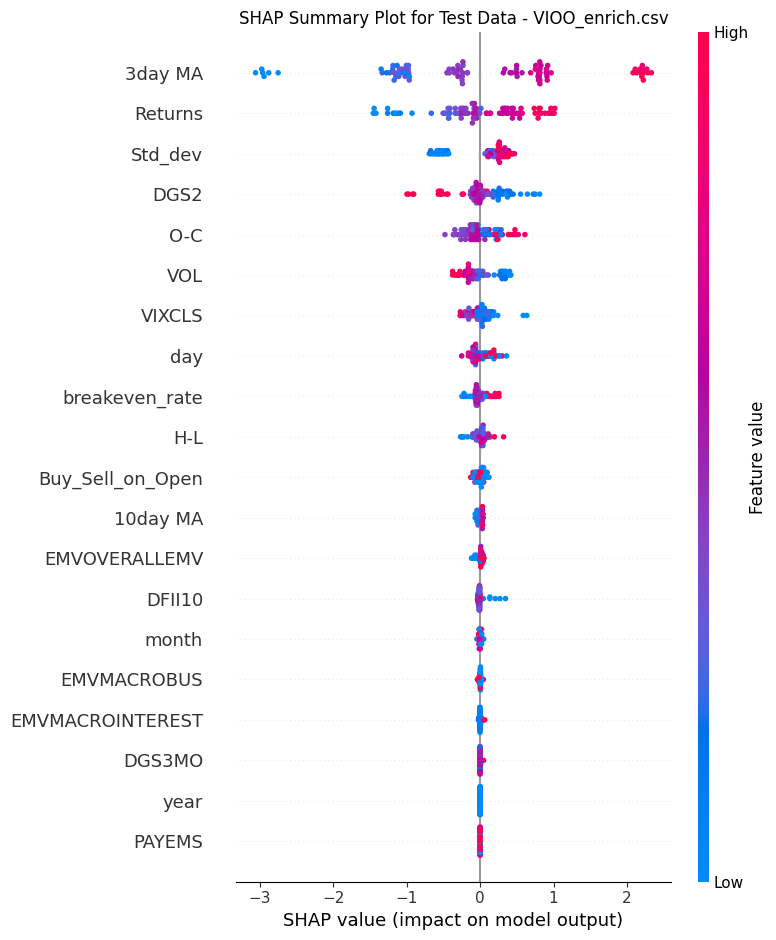

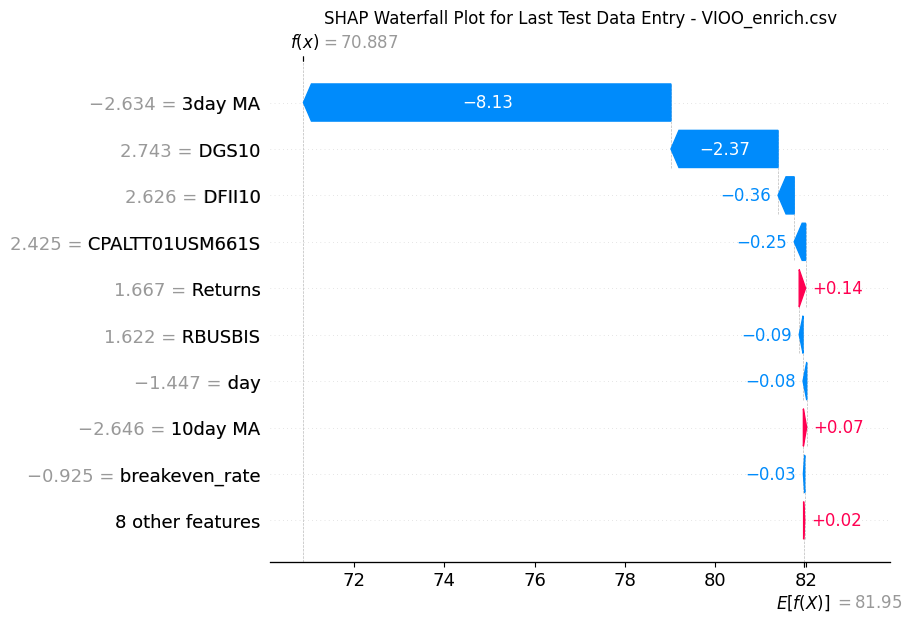

<Figure size 1000x800 with 0 Axes>

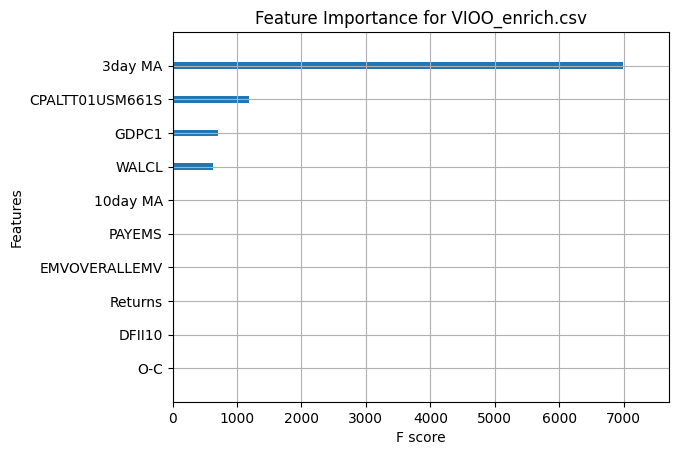

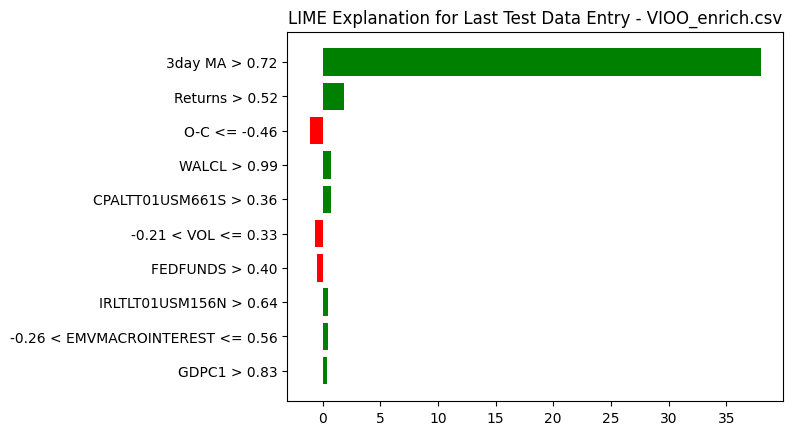

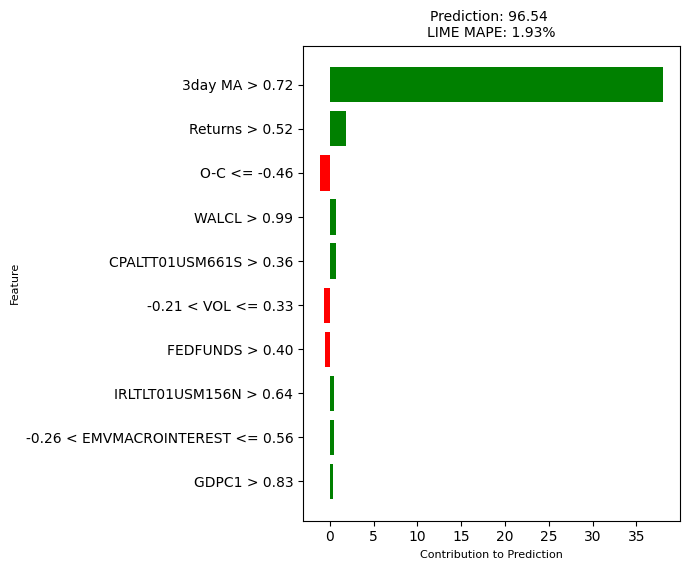

Processing ticker: VOO_enrich.csv
Test performance for VOO_enrich.csv - RMSE: 31.874727137038793, MAPE: 0.06119984926483761


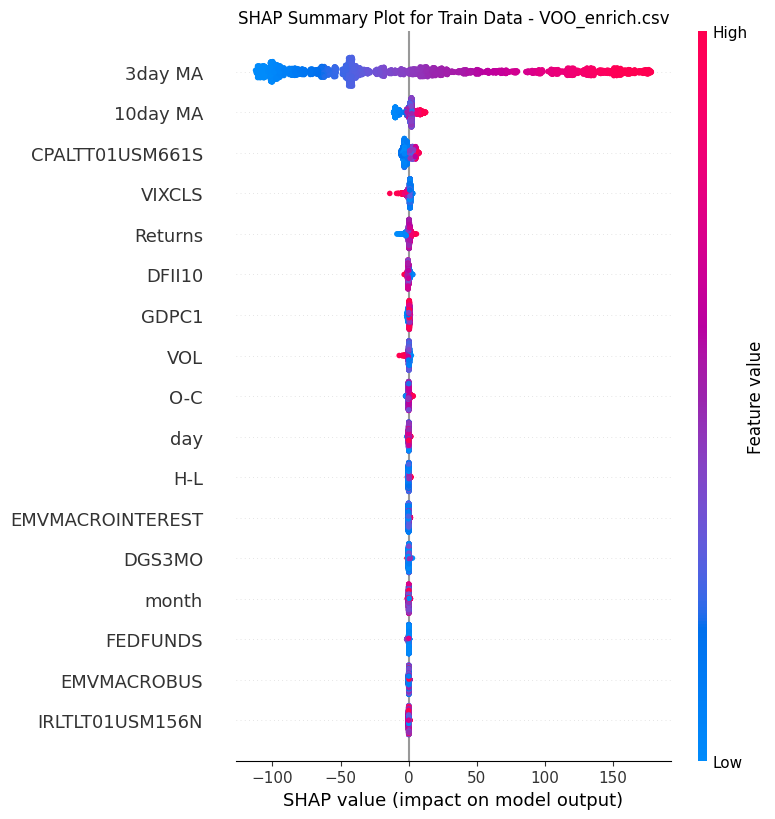

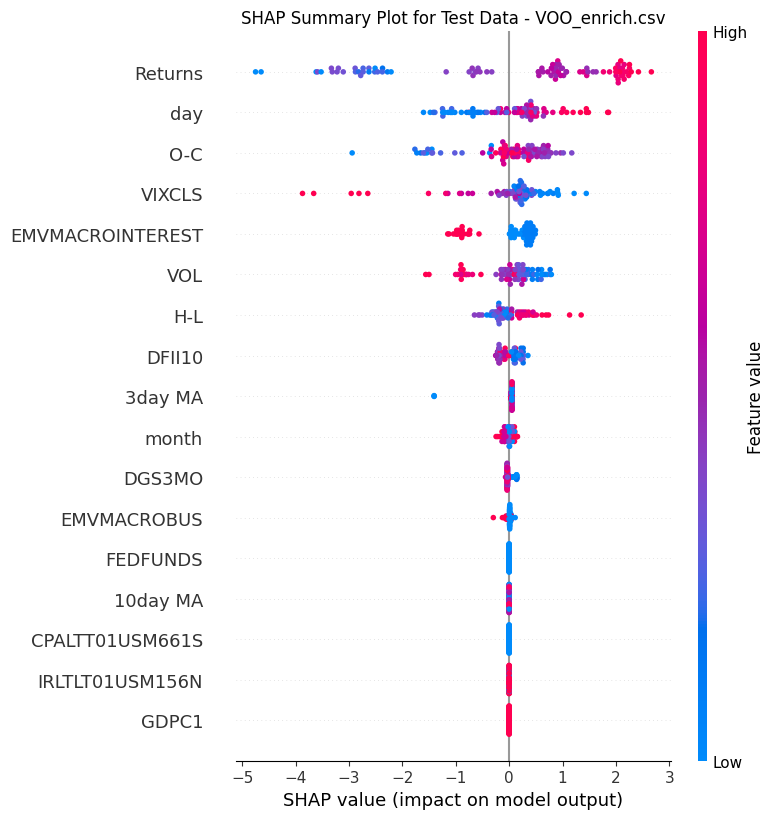

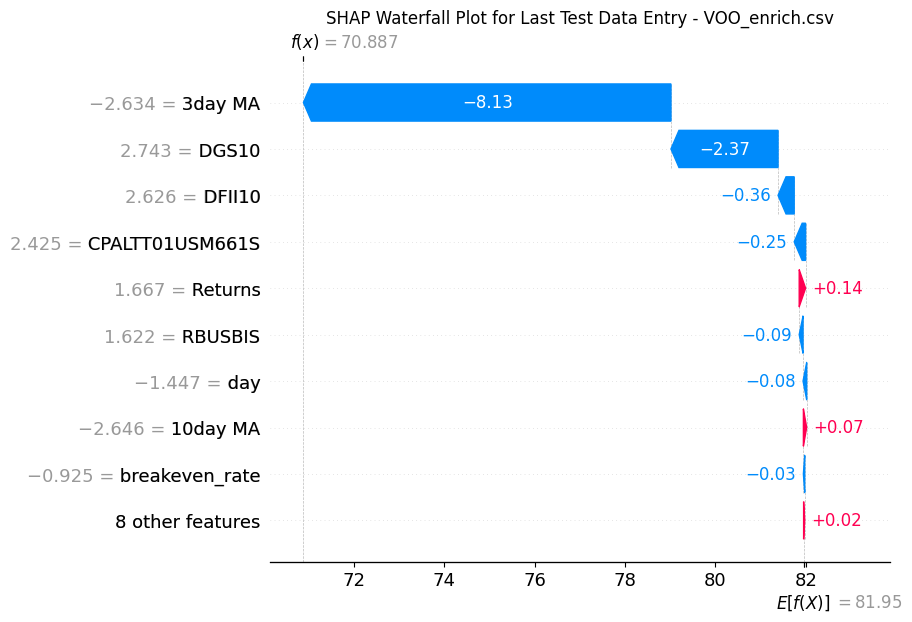

<Figure size 1000x800 with 0 Axes>

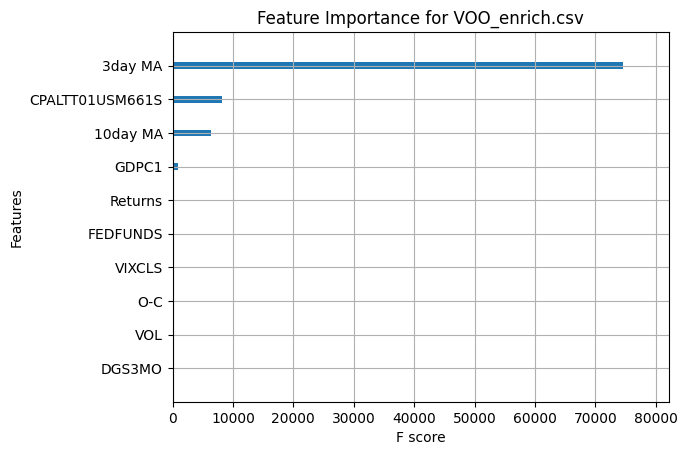

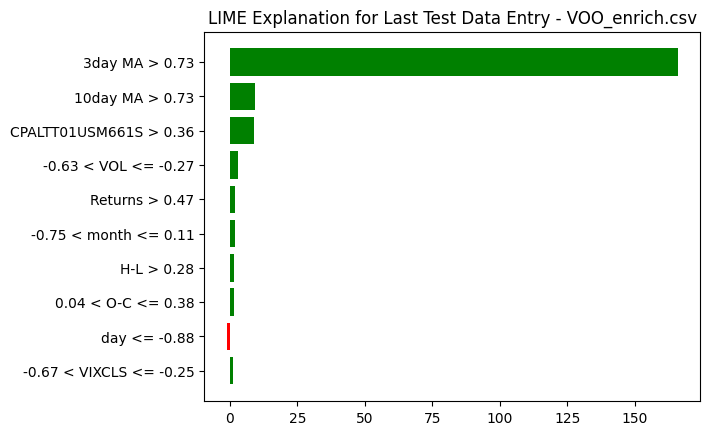

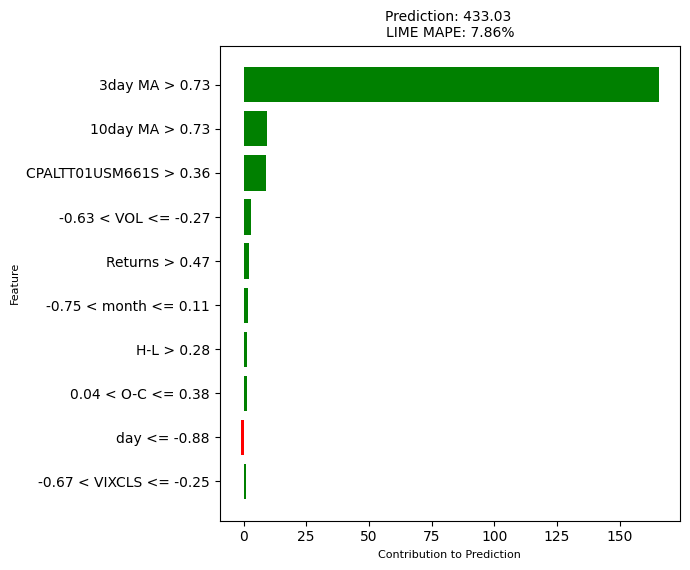

In [31]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import shap  # SHAP for explainability

# Define the selected features for each ticker
selected_features = {
    #'BND_enrich.csv': ["3day MA", "Returns", "DGS10", "10day MA", "breakeven_rate", "VIXCLS", "month", "DFII10", "day", "IRLTLT01USM156N", "EMVMACROBUS", "Std_dev", "EMVOVERALLEMV", "CPALTT01USM661S", "PAYEMS", "EMVMACROINTEREST", "RBUSBIS"],
    'GLD_enrich.csv': ["Returns", "3day MA", "day", "Std_dev", "10day MA", "O-C", "month", "Volume", "EMVMACROINTEREST", "WALCL", "FEDFUNDS", "VIXCLS", "DGS3MO", "DGS10", "EMVMACROBUS", "PAYEMS", "CPALTT01USM661S", "EMVOVERALLEMV", "VOL", "year", "H-L", "GDPC1", "DFII10", "IRLTLT01USM156N", "RBUSBIS", "breakeven_rate", "Buy_Sell", "Buy_Sell_on_Open", "Increase_Decrease"],
    'GOVT_enrich.csv': ["3day MA", "DGS10", "breakeven_rate", "DGS2", "Returns", "DFII10", "EMVOVERALLEMV", "IRLTLT01USM156N", "month", "CPALTT01USM661S", "Std_dev", "PAYEMS", "VIXCLS"],
    'IVOO_enrich.csv': ["VIXCLS", "3day MA", "Returns", "month", "10day MA", "O-C", "EMVOVERALLEMV", "VOL", "WALCL", "CPALTT01USM661S", "Std_dev", "EMVMACROINTEREST", "DFII10", "day", "GDPC1", "year", "EMVMACROBUS", "IRLTLT01USM156N", "DGS10", "PAYEMS", "DGS3MO", "breakeven_rate", "Volume", "Buy_Sell_on_Open", "H-L"],
    'JNK_enrich.csv': ["3day MA", "Returns", "VIXCLS", "10day MA", "month", "O-C", "EMVOVERALLEMV", "breakeven_rate", "Std_dev", "VOL", "EMVMACROINTEREST", "GDPC1", "EMVMACROBUS", "IRLTLT01USM156N", "CPALTT01USM661S", "day", "DFII10", "DGS10", "PAYEMS", "DGS3MO", "Volume"],
    'SPY_enrich.csv': ["Returns", "VIXCLS", "month", "O-C", "10day MA", "Volume", "VOL", "CPALTT01USM661S", "day", "EMVOVERALLEMV", "WALCL", "EMVMACROINTEREST", "breakeven_rate", "GDPC1"],
    'VIOO_enrich.csv': ["Returns", "VIXCLS", "3day MA", "O-C", "10day MA", "month", "CPALTT01USM661S", "GDPC1", "DGS3MO", "Std_dev", "DFII10", "day", "IRLTLT01USM156N", "PAYEMS", "EMVOVERALLEMV", "VOL", "year", "H-L", "EMVMACROINTEREST", "EMVMACROBUS", "FEDFUNDS", "WALCL", "Buy_Sell_on_Open", "DGS2", "breakeven_rate"],
    'VOO_enrich.csv': ["3day MA", "VIXCLS", "Returns", "month", "10day MA", "O-C", "VOL", "CPALTT01USM661S", "GDPC1", "DGS3MO", "EMVMACROINTEREST", "day", "DFII10", "IRLTLT01USM156N", "EMVMACROBUS", "H-L", "FEDFUNDS"]
}

# Manually set which ticker to work on
#ticker = 'BND_enrich.csv'  # Replace with the desired ticker file name

for ticker in selected_features.keys():
    # Re-run the model training without hyperparameter tuning
    np.random.seed(2023)
    print(f"Processing ticker: {ticker}")

    # Processing steps
    stock_data = pd.read_csv(ticker)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data['VOL'] = (stock_data['High'] - stock_data['Low']) / stock_data['Open'] * 100
    stock_data = stock_data.drop(columns=['Open', 'High', 'Low'])
    stock_data = stock_data.dropna(axis=1)

    features = selected_features[ticker]
    newdata = stock_data[['Date'] + features + ['Close']]

    split_point = len(stock_data) - 90
    xr_train = newdata.iloc[:split_point, 1:-1]
    xr_test = newdata.iloc[split_point:, 1:-1]
    yr_train = newdata.iloc[:split_point, -1]
    yr_test = newdata.iloc[split_point:, -1]

    scaler = StandardScaler()
    xr_train_scaled = pd.DataFrame(scaler.fit_transform(xr_train), columns=xr_train.columns)
    xr_test_scaled = pd.DataFrame(scaler.transform(xr_test), columns=xr_test.columns)

    # Train the XGBRegressor model without hyperparameter tuning
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=2023)
    xgb_model.fit(xr_train_scaled, yr_train)

    # Test data performance
    test_preds = xgb_model.predict(xr_test_scaled)
    test_rmse = np.sqrt(mean_squared_error(yr_test, test_preds))
    test_mape = mean_absolute_percentage_error(yr_test, test_preds)
    print(f"Test performance for {ticker} - RMSE: {test_rmse}, MAPE: {test_mape}")

    # SHAP analysis for train data
    explainer_train = shap.Explainer(xgb_model, xr_train_scaled)
    shap_values_train = explainer_train(xr_train_scaled)

    # SHAP summary plot for train data
    plt.figure()
    shap.summary_plot(shap_values_train, xr_train_scaled, feature_names=xr_train_scaled.columns, show=False)
    plt.title(f"SHAP Summary Plot for Train Data - {ticker}")
    plt.tight_layout()
    plt.savefig(f"SHAP_Summary_Plot_Train_{ticker.split('.')[0]}.png")
    plt.show()

    # SHAP analysis for test data
    explainer_test = shap.Explainer(xgb_model, xr_test_scaled)
    shap_values_test = explainer_test(xr_test_scaled)

    # SHAP summary plot for test data
    plt.figure()
    shap.summary_plot(shap_values_test, xr_test_scaled, feature_names=xr_test_scaled.columns, show=False)
    plt.title(f"SHAP Summary Plot for Test Data - {ticker}")
    plt.tight_layout()
    plt.savefig(f"SHAP_Summary_Plot_Test_{ticker.split('.')[0]}.png")
    plt.show()
    
    # Waterfall plot for the last instance in the test set
    plt.figure()  # Create a new figure
    plt.title(f"SHAP Waterfall Plot for Last Test Data Entry - {ticker}")
    shap.waterfall_plot(shap_values[-1], show=False)  # Set show=False to prevent automatic display
    # Save the plot
    plt.savefig(f"SHAP_Waterfall_Plot_Last_Test_{ticker.split('.')[0]}.png", bbox_inches='tight')
    plt.show()
    
    from xgboost import XGBRegressor, plot_importance

    # Feature Importance Plot
    plt.figure(figsize=(10, 8))
    plot_importance(xgb_model, max_num_features=10, importance_type="gain", show_values=False)
    plt.title(f"Feature Importance for {ticker}")
    # Save the plot
    plt.savefig(f"Feature_Importance_{ticker.split('.')[0]}.png", bbox_inches='tight')
    plt.show()

    import lime
    import lime.lime_tabular
    import matplotlib.pyplot as plt

    # LIME Analysis for the last test data entry
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=xr_train_scaled.values,
        feature_names=xr_train_scaled.columns,
        mode='regression'
    )

    lime_exp = lime_explainer.explain_instance(
        data_row=xr_test_scaled.iloc[-1].values,
        predict_fn=xgb_model.predict
    )

    # Generate the LIME explanation plot and save it
    fig = lime_exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for Last Test Data Entry - {ticker}")
    plt.savefig(f"LIME_Explanation_Last_Test_{ticker.split('.')[0]}.png", bbox_inches='tight')
    plt.show()
    
    import matplotlib.pyplot as plt

    # Your existing code
    lime_prediction = xgb_model.predict(xr_test_scaled.iloc[-1].values.reshape(1, -1))[0]
    actual_value = yr_test.iloc[-1]

    # Calculate MAPE for the LIME prediction
    lime_mape = 100 * mean_absolute_percentage_error([actual_value], [lime_prediction])
    mape_text = f'LIME MAPE: {lime_mape:.2f}%'

    # Generate the LIME plot
    fig = lime_exp.as_pyplot_figure()

    # Add titles and adjust layout
    plt.title(f'Prediction: {lime_prediction:.2f} \n{mape_text}', fontsize=10)
    plt.xlabel('Contribution to Prediction', fontsize=8)
    plt.ylabel('Feature', fontsize=8)
    plt.gcf().set_size_inches(7, 5.8)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"LIME_Prediction_Last_Test_{ticker.split('.')[0]}.png", bbox_inches='tight')

    # Show the plot
    plt.show()
    


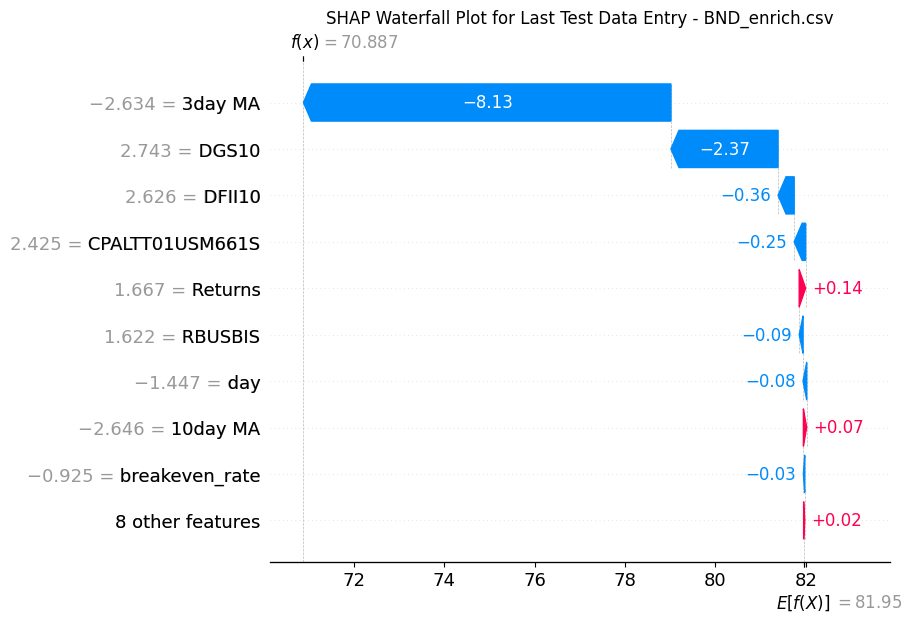

In [27]:

# Waterfall plot for the last instance in the test set
plt.figure()  # Create a new figure
plt.title(f"SHAP Waterfall Plot for Last Test Data Entry - {ticker}")
shap.waterfall_plot(shap_values[-1], show=False)  # Set show=False to prevent automatic display

# Save the plot
plt.savefig(f"SHAP_Waterfall_Plot_Last_Test_{ticker.split('.')[0]}.png", bbox_inches='tight')
plt.show()


<Figure size 1000x800 with 0 Axes>

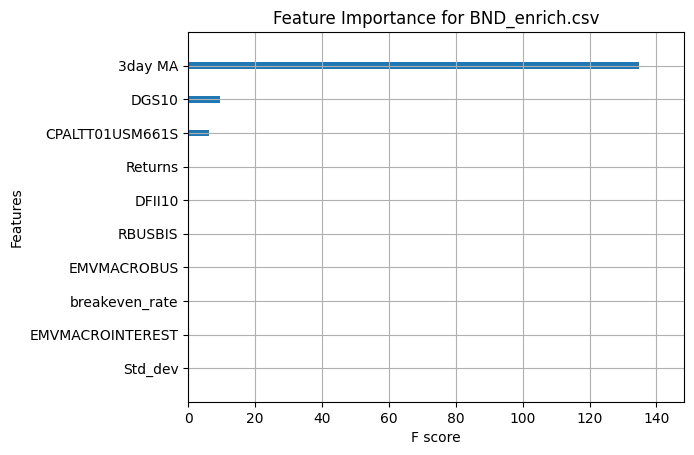

In [28]:
from xgboost import XGBRegressor, plot_importance

# Feature Importance Plot
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, importance_type="gain", show_values=False)
plt.title(f"Feature Importance for {ticker}")

# Save the plot
plt.savefig(f"Feature_Importance_{ticker.split('.')[0]}.png", bbox_inches='tight')
plt.show()

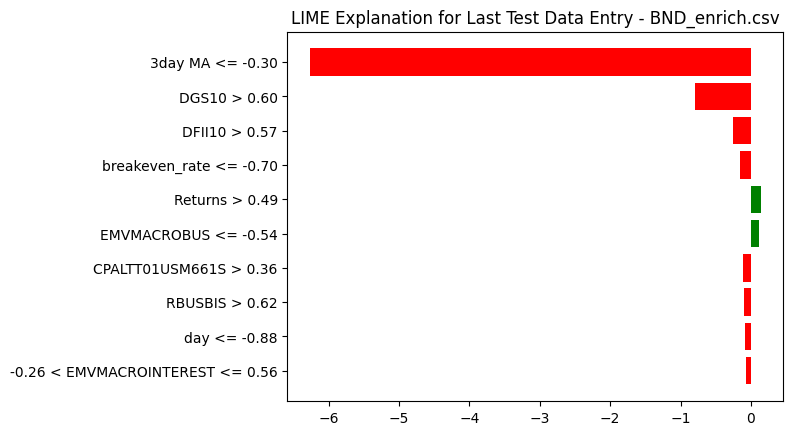

In [29]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# LIME Analysis for the last test data entry
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=xr_train_scaled.values,
    feature_names=xr_train_scaled.columns,
    mode='regression'
)

lime_exp = lime_explainer.explain_instance(
    data_row=xr_test_scaled.iloc[-1].values,
    predict_fn=xgb_model.predict
)

# Generate the LIME explanation plot and save it
fig = lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Last Test Data Entry - {ticker}")
plt.savefig(f"LIME_Explanation_Last_Test_{ticker.split('.')[0]}.png", bbox_inches='tight')
plt.show()


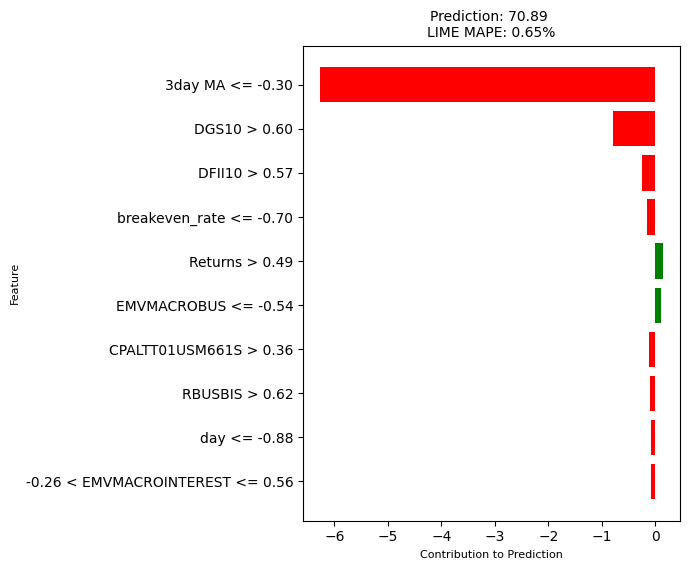

In [30]:
import matplotlib.pyplot as plt

# Your existing code
lime_prediction = xgb_model.predict(xr_test_scaled.iloc[-1].values.reshape(1, -1))[0]
actual_value = yr_test.iloc[-1]

# Calculate MAPE for the LIME prediction
lime_mape = 100 * mean_absolute_percentage_error([actual_value], [lime_prediction])
mape_text = f'LIME MAPE: {lime_mape:.2f}%'

# Generate the LIME plot
fig = lime_exp.as_pyplot_figure()

# Add titles and adjust layout
plt.title(f'Prediction: {lime_prediction:.2f} \n{mape_text}', fontsize=10)
plt.xlabel('Contribution to Prediction', fontsize=8)
plt.ylabel('Feature', fontsize=8)
plt.gcf().set_size_inches(7, 5.8)
plt.tight_layout()

# Save the plot
plt.savefig(f"LIME_Prediction_Last_Test_{ticker.split('.')[0]}.png", bbox_inches='tight')

# Show the plot
plt.show()
